true_cov =tensor([[17.9240,  4.1875],
        [ 4.1875, 16.8464]])
true_mean =tensor([4.6568, 2.5737])


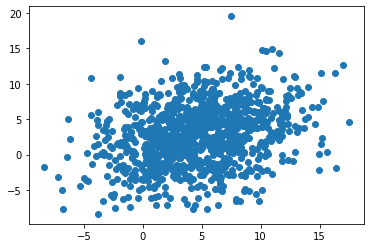

In [107]:
import torch
d=2
mu_0 = torch.zeros(2)
Psi_0 = torch.eye(2)
lbda = 1
nu = 10
true_sigma = torch.distributions.Wishart(nu,torch.inverse(Psi_0)).sample()
true_mean = torch.distributions.MultivariateNormal(mu_0,true_sigma/lbda).sample()
N = 1000
data  = torch.distributions.MultivariateNormal(true_mean, true_sigma).sample([N])

import matplotlib.pyplot as plt
plt.scatter(data[:10000,0], data[:10000,1])
print('true_cov =' + str(true_sigma))
print('true_mean =' + str(true_mean))

In [108]:
lbda_N = lbda + N
nu_N = nu + N
empirical_mean = torch.mean(data, dim =0)
mu_N = (lbda*mu_0 + N*empirical_mean)/lbda_N
S = torch.cov(data.T)*(N-1)
temp = (empirical_mean-mu_0).unsqueeze(-1)
Psi_N = Psi_0 + S + (lbda*N*temp@temp.T)/(lbda_N)

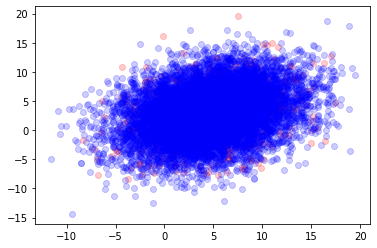

In [109]:
sigma = torch.inverse(torch.distributions.Wishart(nu_N,torch.inverse(Psi_N)).sample())
mu = torch.distributions.MultivariateNormal(mu_N, sigma/lbda_N).sample()
new_data = torch.distributions.MultivariateNormal(mu, sigma).sample([10000])

plt.scatter(data[:10000,0], data[:10000,1], color='red', alpha = .2)
plt.scatter(new_data[:10000,0], new_data[:10000,1], color = 'blue', alpha = .2)

In [110]:
print('estimated sigma = ' + str(sigma))
print('estimated mean = ' + str(mu))

estimated sigma = tensor([[19.3374,  5.2926],
        [ 5.2926, 17.7166]])
estimated mean = tensor([4.6055, 2.9930])


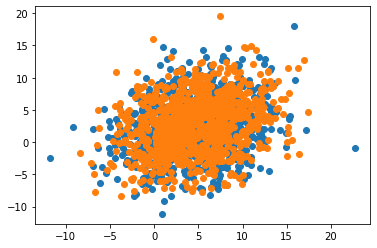

In [111]:
import pyro
posterior_predictive = pyro.distributions.MultivariateStudentT(nu_N - d + 1, mu_N,torch.cholesky(Psi_N*(lbda_N+1)/(lbda_N*(nu_N - d + 1))))
posterior_samples = posterior_predictive.sample([1000])
plt.scatter(posterior_samples[:,0].numpy(), posterior_samples[:,1].numpy())
plt.scatter(data[:,0].numpy(), data[:,1].numpy())

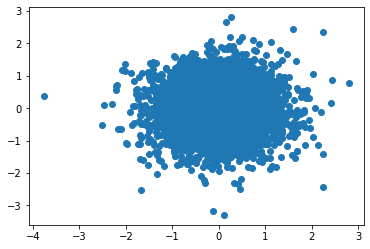

In [118]:
prior_predictive = pyro.distributions.MultivariateStudentT(nu - d + 1, mu_0,torch.cholesky(Psi_0*(lbda+1)/(lbda*(nu- d + 1))))
prior_predictive_samples = posterior_predictive.sample([10000])
plt.scatter(posterior_samples[:,0].numpy(), posterior_samples[:,1].numpy())

In [119]:
true_sigma = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(Psi_0)).sample([10000]))
true_mean = torch.diagonal(torch.distributions.MultivariateNormal(mu_0,true_sigma/lbda).sample([10000]),0,1,2)
print(true_mean.shape)
data  = torch.distributions.MultivariateNormal(true_mean, true_sigma).sample()

torch.Size([10000, 2])


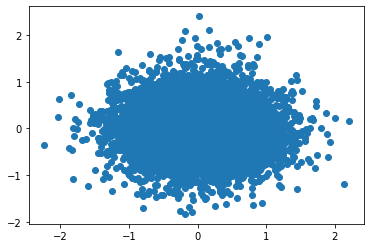

In [120]:
plt.scatter(data[:,0].numpy(), data[:,1].numpy())